# Model_VAE_Regular_CNN

## V3 settings
- VAE instead of AE

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

# import image based recommendation module
from ibfilter import ImageBasedRecommendation

---
## Data Prep
---

In [3]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:501]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [4]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_test/")))

500


In [5]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [6]:
# # Define transformations and initialize Dataset
# transform_steps = transforms.Compose([transforms.ToTensor(),
#                                       transforms.CenterCrop(200),
#                                       transforms.Normalize(mean=[0], std=[1.0])
#                                      ])
# manga_dataset = MangaDataset("../assets/character_images/character_images_grayscale_test", transform_steps)

In [7]:
# # Set DataLoader

# # Split train and data
# train_size = int(manga_dataset.__len__() * 0.75)
# val_size = int(manga_dataset.__len__() - train_size)
# train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # All dataloader
# all_data_loader = DataLoader(manga_dataset, batch_size=32)

In [8]:
# # Check Dataset
# img_ex = train_dataset.__getitem__(0)
# print(len(img_ex))
# print(type(img_ex))
# print(img_ex[0].shape)

# # Check DataLoader
# input_tensor, output_tensor, character_id = next(iter(train_loader))
# print(f"input batch shape: {input_tensor.size()}")
# print(f"output batch shape: {output_tensor.size()}")
# img_ex = input_tensor[0].squeeze()
# plt.imshow(img_ex, cmap="gray")
# plt.show()

In [9]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * train_ratio)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    all_data_loader = DataLoader(manga_dataset, batch_size=batch_size)
    return train_loader, val_loader, all_data_loader

---
## VAE
---

In [140]:
# single encoder layer
def single_encoder_layer(in_c, out_c, k, s, p):
    layer = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p),
                          nn.BatchNorm2d(out_c),
                          nn.ReLU(inplace=True))
    return layer


# single decoder layer
def single_decoder_layer(in_c, out_c, k, s, p, op=0):
    layer = nn.Sequential(nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p, output_padding=op),
                          nn.BatchNorm2d(out_c),
                          nn.ReLU(inplace=True))
    return layer


# custom loss function
def bce_kld_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# VAE model
class VAE(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        
        # encoding layers
        self.conv1 = single_encoder_layer(1, 3, 3, 1, 1) # 1 x 200 x 200 -> 3 x 200 x 200
        self.conv2 = single_encoder_layer(3, 32, 5, 3, 1) # 3 x 200 x 200 -> 32 x 66 x 66
        self.conv3 = single_encoder_layer(32, 64, 5, 3, 0) # 32 x 66 x 66 -> 64 x 21 x 21
        self.conv4 = single_encoder_layer(64, 128, 5, 3, 0) # 64 x 21 x 21 -> 128 x 6 x 6
        self.conv5 = single_encoder_layer(128, 256, 3, 3, 1) # 128 x 6 x 6 -> 256 x 2 x 2

        # latent space layers
        self.fc_mu = nn.Linear(1024, 128) # 256 x 2 x 2 = 1024
        self.fc_logvar = nn.Linear(1024, 128)
        self.fc_rep = nn.Linear(128, 1024)
        
        # decoding layers
        # (kernel-1) + (input_size-1)*stride - 2*pad + 1
        self.deconv1 = single_decoder_layer(256, 128, 5, 3, 1) # 256 x 2 x 2 -> 128 x 6 x 6
        self.deconv2 = single_decoder_layer(128, 64, 5, 4, 2) # 128 x 6 x 6 -> 64 x 21 x 21
        self.deconv3 = single_decoder_layer(64, 32, 7, 3, 1, 1) # 64 x 21 x 21 -> 32 x 66 x 66
        self.deconv4 = single_decoder_layer(32, 3, 7, 3, 1) # 32 x 66 x 66 -> 3 x 200 x 200
        # last one needs to go through sigmoid, and do 3 x 200 x 200 -> 1 x 200 x 200
        self.deconv5 = nn.Sequential(nn.ConvTranspose2d(3, 1, kernel_size=3, stride=1, padding=1),
                                     nn.BatchNorm2d(1),
                                     nn.Sigmoid())


    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(self.device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, log_var = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    def encoder(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x) # 256 x 2 x 2
        h = x.view(x.size(0), -1) # flatten: 256 x 2 x 2 -> 1024
        z, mu, log_var = self.bottleneck(h)
        return z, mu, log_var

    def decoder(self, z):
        z = self.fc_rep(z)
        z = z.view(z.size(0), 256, 2, 2) # unflatten: 1024 -> 256 x 2 x 2
        z = self.deconv1(z) # 256 x 2 x 2 -> 128 x 6 x 6 and so on
        z = self.deconv2(z)
        z = self.deconv3(z)
        z = self.deconv4(z)
        z = self.deconv5(z)
        return z

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        z = self.decoder(z)
        return z, mu, log_var

---
## Test runs
---

In [141]:
# test VAE
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=16)

# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = VAE(device=device)
model.train()
model.to(device)

# set loss function, optimizer
# criterion = nn.MSELoss()
# kldiv = nn.KLDivLoss(reduction="batchmean")
vae_params = list(model.parameters())
optimizer = optim.Adam(vae_params, lr=0.005)

# train
losses = []

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        z, mu, log_var = model(train_img)
        # print(type(z), type(target_img))

        # loss = kldiv(z, target_img)
        loss = bce_kld_loss(z, target_img, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / counter
    losses.append(avg_loss)

cuda


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


[892311.4375, 808162.3020833334, 759093.5625, 740021.6979166666, 727957.4635416666, 721252.1770833334, 710859.0677083334, 707991.7083333334, 698388.0442708334, 693965.5182291666]


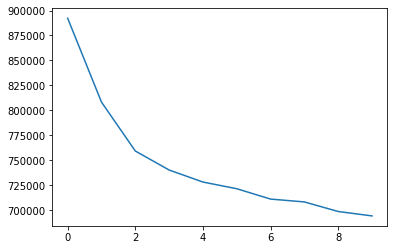

In [142]:
# quick plot of training losses
plt.plot(losses)
print(losses)

In [143]:
model.eval()

# validate
val_losses = []

for epoch in tqdm(range(10)):
    with torch.no_grad():
        running_loss = 0.0
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            z, mu, log_var = model(train_img)

            # calculate loss
            loss = bce_kld_loss(z, target_img, mu, log_var)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        val_losses.append(avg_loss)

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.97it/s]


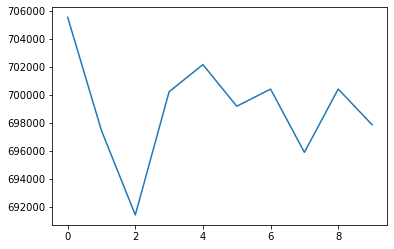

In [144]:
# quick plot of training losses
plt.plot(val_losses)

---
## Train
---

In [145]:
# version setting
version = "v3"

In [ ]:
# visualize model
x = torch.zeros(16, 1, 200, 200, dtype=torch.float, requires_grad=False)
model = VAE(device=device)
model.train()
model.to(device)
z, mu, log_var = model(x.to(device))
make_dot(z, params=dict(list(model.named_parameters()))).render(version+"_inception_ae_torchviz", format="png")

In [146]:
# Putting training and validation into methods
def train_step(model, train_loader, optimizer, device):
    model.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        z, mu, log_var = model(train_img)

        loss = bce_kld_loss(z, target_img, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / counter
    return avg_loss


def val_step(model, val_loader, device):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            z, mu, log_var = model(train_img)

            # calculate loss
            loss = bce_kld_loss(z, target_img, mu, log_var)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        return avg_loss

In [147]:
# train and validate to check that the methods work

# redo the settings all again

# set data
# better with batch_size=64 rather than 32 (32 can end up with training curve not going down)
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      # transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=16)

# prep model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = VAE(device=device)
model.train()
model.to(device)

# set optimizer
vae_params = list(model.parameters())
optimizer = optim.Adam(vae_params, lr=0.005)

# check that it works
EPOCHS = 100
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)
    # print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(model, val_loader, device=device)
    val_losses.append(val_loss)
    # print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_vae = copy.deepcopy(model)
        torch.save(best_vae.state_dict(), "../assets/character_images/models_and_embeddings/vae_model_"+version+".pt")
        min_loss = val_loss
        

cuda


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.00s/it]


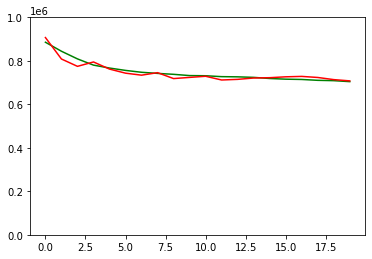

In [148]:
# plot training & validation losses
# print(train_losses[0:10])
plt.plot(train_losses,"g", val_losses, "r")
plt.ylim(0.0, 1000000)
plt.show()

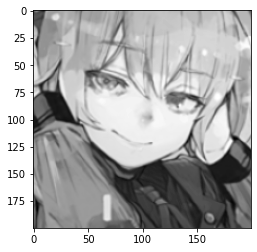

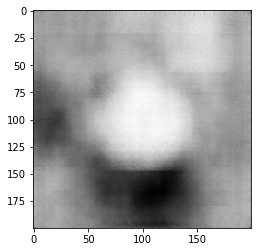

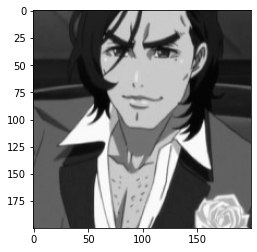

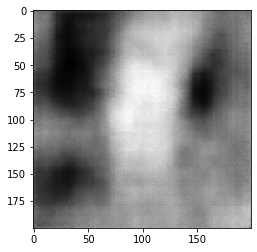

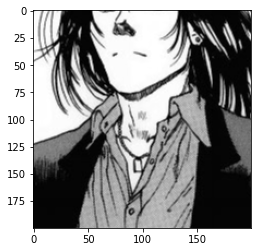

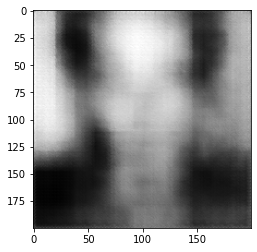

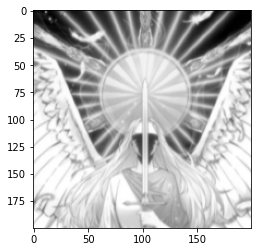

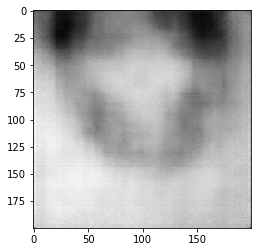

In [149]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

model.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        z, mu, log_var = model(train_img)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, out_img in zip(train_img[0], z[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(out_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

## Interpretation of v.3 (Variational Autoencoder with CNN)
- Reconstructions are not very good
- Although, similar image results are ok. Doesn't seem that much different from v1 or v2

---
## Create embedding
---

In [151]:
# create embedding

model.eval()
embedding = torch.zeros((1, 128))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in all_data_loader:
        train_img = train_img.to(device)
        z, mu, log_var = model.encoder(train_img)
        z = z.cpu()
        # print(z.shape)
        # enc_output = encoder(train_img).cpu()
        embedding = torch.cat((embedding, z), 0)
        character_ids.append(character_id)

In [152]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy", np_character_ids)

len of character_ids:  500
shape of embedding:  torch.Size([500, 128])
shape of flattened embedding:  (500, 128)


---
## Similarity calculations (Character-based, Title-based)
---

In [4]:
# initialize
ibr_search = ImageBasedRecommendation("/mnt/disks/sdb/home/dy0904k/assets/character_images/character_images_grayscale/", "v3")

model version:  v3


Queried character:  ['Jirou Azuma']  who appears in:  ['BLACK TORCH']


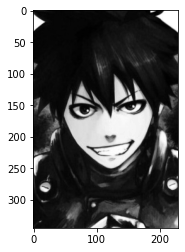

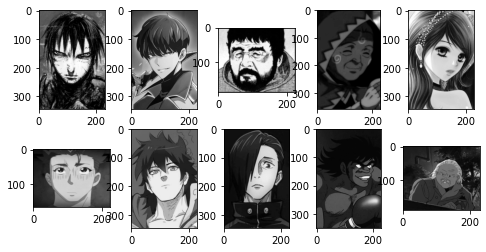

Similar characters (in the order of appearance)
Character:  ['Killy']  who appears in :  ['BLAME!' 'NOiSE' 'Blame! Gakuen And So On' 'BLAME!²'
 'Blame!: Denki Ryoushi Kiken Kaisou Dasshutsu Sakusen' 'BLAME']
Character:  ['Jin-Hyeok Kang']  who appears in :  ['Na Honja Mallep Newbie']
Character:  ['Mr. Ita']  who appears in :  ['Homunculus']
Character:  ['Yaobikuni']  who appears in :  ['Mugen no Juunin']
Character:  ['Teru Kurebayashi']  who appears in :  ['Dengeki Daisy']
Character:  ['Kamioka']  who appears in :  ['Shijou Saikyou no Deshi Kenichi']
Character:  ['Han Ye']  who appears in :  ['Yao Shen Ji']
Character:  ['Junpei  Yoshino']  who appears in :  ['Jujutsu Kaisen']
Character:  ['Harimao']  who appears in :  ['Ashita no Joe']
Character:  ['Nezu']  who appears in :  ['AKIRA']
[101517  30936  30149  30664  86707  30658  31303  35255 137280  30988]


In [5]:
res = ibr_search.recommend_titles_from_similar_characters(query_character_id=137304, top_n=10)
print(res)

Querying title:  ['Berserk']


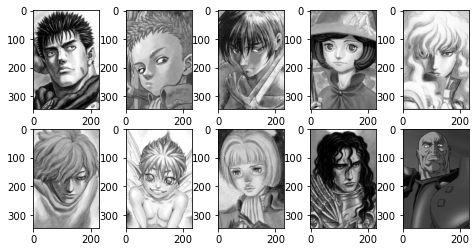

Similar title:  ['Ao no Exorcist']


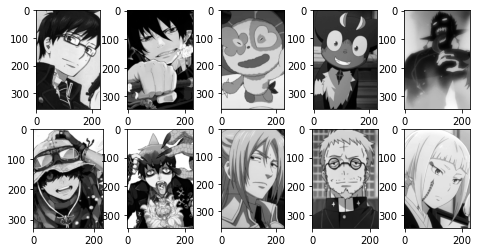

Similar title:  ['Summer Time Render']


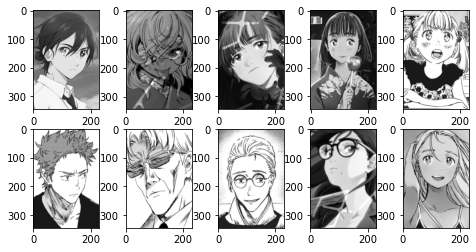

Similar title:  ['Shingeki no Kyojin']


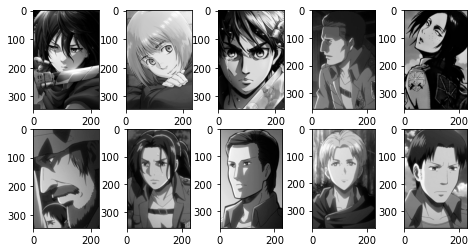

[43492, 102989, 53390]


In [6]:
res = ibr_search.recommend_titles_from_similar_image_embedding(query_title_id=30002, top_n=3)
print(res)